# Comparison of softmax and micropatch distribution 

# CHECKLIST 
1) [x] Import turf imagery and SfM estimates (and ground truth)
2) [x] Implement pose estimations and 'TRUTH' for individual patches
3) [x] Divide each patch into micro patches
4) [x] Calculate error vector for each micropatch
5) [x] Generate mean and covariance data for a set of micropatches
6) [x] Calculate softmax distbribution for full PATCHES
7) [x] Plot softmax vs micropatch distribution

Unknowns

$$
\mathbf{x} = [X, Y, Z, \phi, \theta, \psi]^T
$$


Generating SSD values for n micropatches

$$
\mathrm{SSD}_i(\Delta x, \Delta y)
=
\sum_{(p,q)}\sum_{ \in A_g}
\Big[
    I_i(p + \Delta x,\; q + \Delta y)
    - I_s(p, q)
\Big]^2
$$

The correction vector over each micropatch i represented by 

$$
\mathbf{e}_i
=
\begin{bmatrix}
e_x \\
e_y
\end{bmatrix}
=
\arg\min_{\Delta x,\;\Delta y}
\mathrm{SSD}_i(\Delta x,\Delta y)
$$

Across n micropatches 

MEAN

$$
\boldsymbol{\mu}
=
\begin{bmatrix}
\bar e_x \\
\bar e_y
\end{bmatrix}
=
\frac{1}{n}\sum_{i=1}^{n}
\begin{bmatrix}
e_{x,i} \\
e_{y,i}
\end{bmatrix}
$$


VARIANCE 
$$
R_p
=
\begin{bmatrix}
\sigma_x^2 & \sigma_{xy} \\
\sigma_{xy} & \sigma_y^2
\end{bmatrix}
=
\frac{1}{n-1}
\sum_{i=1}^{n}
\Bigg(
\begin{bmatrix}
e_{x,i} \\
e_{y,i}
\end{bmatrix}
-
\begin{bmatrix}
\bar e_x \\
\bar e_y
\end{bmatrix}
\Bigg)
\Bigg(
\begin{bmatrix}
e_{x,i} \\
e_{y,i}
\end{bmatrix}
-
\begin{bmatrix}
\bar e_x \\
\bar e_y
\end{bmatrix}
\Bigg)^{T}
$$



In [1]:
import numpy as np 
import cv2
import pickle
from matplotlib.patches import Ellipse
import pandas as pd

from groundNAV_agent import *
from distb_plotting_utils import *
from microp_distb import *


# SAVE YOUR WORK
%load_ext autoreload
%autoreload 2
%autosave 180

/home/daniel-choate/miniconda3/envs/py39/lib/python3.9/site-packages/dash/dash.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, parse_version


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Autosaving every 180 seconds


In [2]:
# SfM files 
images_colm = '../TurfData/SfM_soln/images.txt'
cameras_colm = '../TurfData/SfM_soln/cameras.txt'
pts3d_colm = '../TurfData/SfM_soln/points3D_f.txt'

# Local images - folder
# im_local = '../TurfData/local_imgs_10' # With 10 local images 
im_local = '../TurfData/local_imgs_5' # With 5 local images

# Satellite reference image
sat_ref = '../TurfData/TurfSat.jpg'

In [3]:
# Create class 
gnav = gNAV_agent(images_colm, cameras_colm, pts3d_colm, im_local, sat_ref)

### Implement pose estimations and ground truth solutions

In [4]:
# SET REFERENCE FRAME
# Set reference frame - transform to ground-parallel coordinate frame 
tform_ref_frame = gnav.set_ref_frame(gnav.pts_gnd_idx)
tform_ref_frame_pts = gnav.inv_homog_transform(tform_ref_frame)
print("\nReference frame transformation\n", tform_ref_frame_pts)

# Transfer all points to new coordinate system
origin_ref, scene_pts_ref, scene_vec_ref = gnav.unit_vec_tform(gnav.scene_pts, gnav.origin_w, tform_ref_frame_pts)


Reference frame transformation
 [[-1.55069060e-03  9.81197008e-01  1.93002661e-01 -1.21025836e-01]
 [-1.42845166e-01 -1.91240997e-01  9.71093270e-01  1.86102525e+00]
 [ 9.89743833e-01 -2.60636319e-02  1.40455805e-01  7.28134156e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


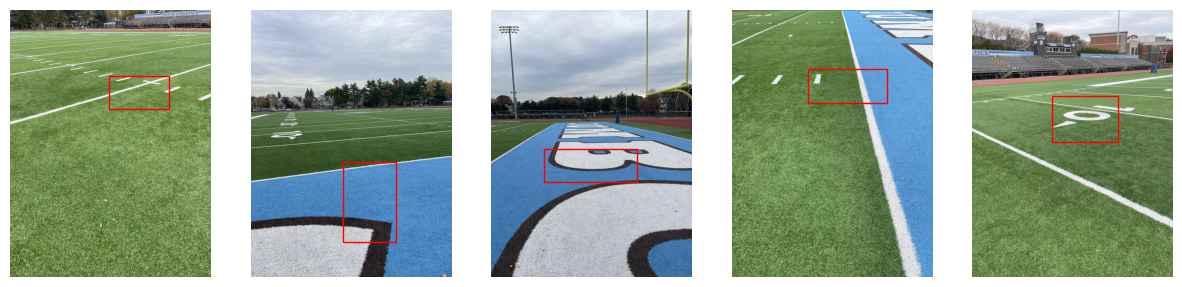

In [5]:
# Import mosaic parameters - arbitrarily obtained, can be modified
mosaic_params = np.load('../TurfData/GP_sections/mosaic_params.npy')
# Grab specified image points from local images 
gnav.grab_image_pts_tot(mosaic_params)

plt.figure(figsize=(15,8))
gnav.plot_gnd_pts()

In [6]:
# Generate projection of image sections 
for i in range(len(gnav.images_dict)):
    # STEP 1: Unit vectors in camera coords 
    pts_vec_c, pts_rgb_gnd = gnav.unit_vec_c(i)
    gnav.im_mosaic[i] = {'rgbc': pts_rgb_gnd}

    # STEP 2: Transformation matrix moves from camera coords to world coords
    id = gnav.im_ids[i]
    homog_w2c, homog_c2w = gnav.get_pose_id(id,i)
    # print('Homogeneous transformation from world to camera \n', homog_c2w)
    # print('\n Homogeneous transformation from camera to world \n', homog_w2c)

    # STEP 3: Transform to world coords
    origin_c, pts_loc_w, pts_vec_w = gnav.unit_vec_tform(pts_vec_c, gnav.origin_w, homog_c2w)
    # print('\n New camera frame origin = ', origin_c)
    
    # STEP 4: Get new points 
    ranges, new_pts_w = gnav.pt_range(pts_vec_w, homog_c2w, origin_c, i)
    # print('\nNew Points \n', new_pts_w)

    # STEP 5: Transfer points to reference frame
    __, new_pts_r, pts_vec_r = gnav.unit_vec_tform(new_pts_w, gnav.origin_w, tform_ref_frame_pts)

    # Convert points to grayscale 
    gray_c = gnav.conv_to_gray(gnav.im_mosaic[i]['rgbc'],i)
    # print(gray_c)

    # Put new points and grayscale colors in image mosaic
    gnav.im_mosaic[i]['pts'] = new_pts_r
    gnav.im_mosaic[i]['color_g'] = gray_c
    
    print("\nDone image ", i)


Done image  0

Done image  1

Done image  2

Done image  3

Done image  4


In [7]:
# IMPLEMENTING 'TRUTH SOLUTION' - once I find it in my files 

ind_params = np.load("../../s2/TerrainNav/ind_params.npy")
# print(ind_params)

gnav.ind_params_truth = ind_params
gnav.implement_guess_ind(gnav.ind_params_truth)

In [8]:
# # Initial guess parameters 
# # 5 image solution
# scale, yaw, x_g, y_g = 80, np.deg2rad(140), -52, 20
# # BEST after CONVERGENCE
# scale = 80.14819958
# yaw = 2.44777939
# x_g = -55.46495001
# y_g = 21.62910054

# tform_guess = gnav.tform_create(x_g,y_g,0,0,0,yaw)
# gnav.best_guess_tform = tform_guess
# gnav.best_guess_scale = scale

# # Implement
# gnav.implement_guess(gnav.best_guess_tform, gnav.best_guess_scale)

In [9]:
# Create visualization
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Image mosaic with reference map (initial guess)")

gnav.mosaic_w_ref_visualization(vis)

libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 80
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 80
pci id for fd 80: 8086:a7a0, driver iris
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using DRI3 for screen 0


### Divide each patch into micro-patches

- [x] Grab patch from ground image
- [x] Project patch onto satellite image (trapezoid)
- [x] Find bounds of trapezoid
- [x] Divide bounding box into uniform squares
- [x] Check which squares are fully within the trapezoid

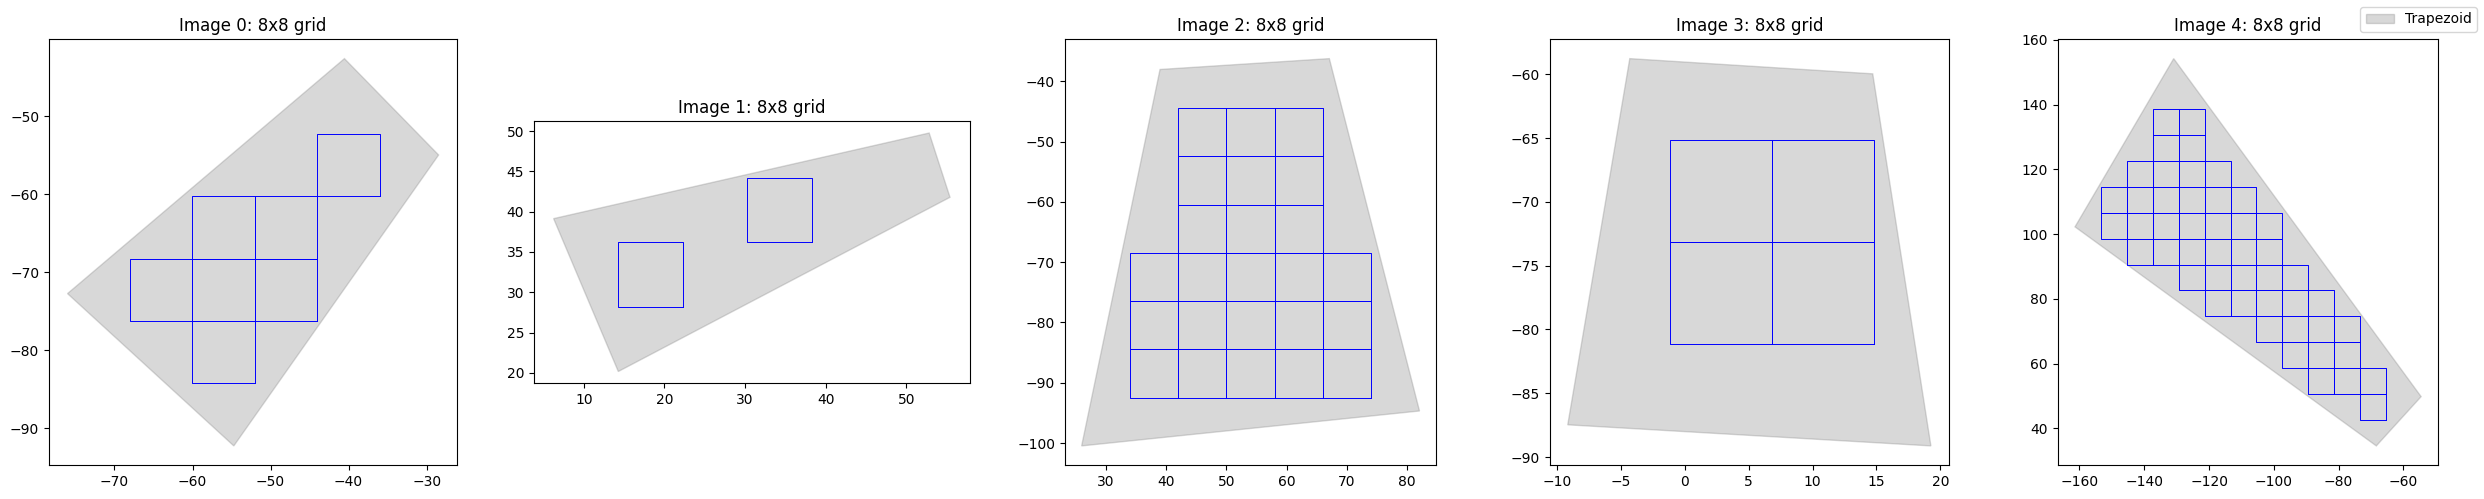

In [10]:
n = 8
micro_ps = gnav.micropatch_division(n)
gnav.micro_ps_local = copy.deepcopy(gnav.micro_ps) # KEEPING ORIGINAL, LOCAL IS WHAT WE EDIT
gnav.plot_traps_w_microps(n)

In [11]:
print([len(micro_ps[i]) for i in range(5)])

[7, 2, 24, 4, 48]


In [12]:
# # Check that the points are at least proper

# # PLOTTING THE NEW SCENE MOSAIC

# # Use open3d to create point cloud visualization 
# # Create visualization 
# vis = o3d.visualization.Visualizer()
# vis.create_window(window_name="Mosaic scene with satellite reference")

# # Create axes @ origin
# axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10)
# # vis.add_geometry(axis_origin)

# # Add image patches
# # for i in range(len(gnav.images_dict)):
# # for i in range(2):
# #     cloud = o3d.geometry.PointCloud()
# #     cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[i]['pts'])
# #     cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[i]['color_g'])
# #     vis.add_geometry(cloud)


# # Create point cloud for image points
# for i in range(len(gnav.images_dict)):
#     for j in range(len(micro_ps[i])):
#         # print(j)
#         cloud_micro = o3d.geometry.PointCloud()
#         cloud_micro.points = o3d.utility.Vector3dVector(micro_ps[i][j]['pts'])
#         # cloud_micro.paint_uniform_color([.75, 0.001*j, 0.002*j])
#         cloud_micro.colors = o3d.utility.Vector3dVector(micro_ps[i][j]['color_g'])
#         vis.add_geometry(cloud_micro)



# # Create point cloud for reference cloud (satellite)
# ref_cloud = o3d.geometry.PointCloud()
# ref_cloud.points = o3d.utility.Vector3dVector(gnav.ref_pts)
# ref_cloud.colors = o3d.utility.Vector3dVector(gnav.ref_rgb)
# vis.add_geometry(ref_cloud)

# # Run and destroy visualization 
# vis.run()
# vis.destroy_window()

### SSD Process:
- [x] Gather satellite points from each individual patch
- [x] Grab nearest neighbors of patch points 
- [x] Gather SSDs for each micropatch
- [x] Calculate minimum for each patch
- [x] Generate vector to minimum location
- [x] Plot vectors across each micropatch

In [13]:
ssds_curr_micro = [{} for _ in range(len(gnav.images_dict))]
gnav.ssds_curr_micro = [{} for _ in range(len(gnav.images_dict))]

In [14]:
# # # Loop through images and patches
# n_ssd = 5

# for imnum in range(len(gnav.images_dict)):
#     for mp in range(len(gnav.micro_ps[imnum])):
#         ssds = gnav.ssd_nxn_micro(n_ssd, imnum, mp)
#         gnav.ssds_curr_micro[imnum][mp] = ssds
#     print(f'Done image {imnum}')

In [1]:
# # Save data as pickle 
# fn = 'ssd_test_8x8_5n_T.pkl'
# with open(fn, 'wb') as f:
#     pickle.dump(gnav.ssds_curr_micro, f)

In [16]:
# Import pickle data structure so we do not have to run again
# Load
with open('ssd_test_8x8_5n_T.pkl', 'rb') as f:
    ssds_curr_micro_pkl = pickle.load(f)

### Minimum SSD and patch distribution 

In [17]:
# for imnum in range(len(gnav.images_dict)):
#     for mp in range(len(gnav.micro_ps[imnum])):
#         diff = gnav.ssds_curr_micro[imnum][mp] - ssds_curr_micro_pkl[imnum][mp]
#         print("DIFF", diff)

In [18]:
gnav.ssds_curr_micro = ssds_curr_micro_pkl

In [19]:
gnav.distb_vecs = [{} for _ in range(gnav.im_num)]
gnav.distb_pts = [{} for _ in range(gnav.im_num)]



# gnav.distb_mean_var = [{} for _ in range(gnav.im_num)]
gnav.distb_mean_var_blue = [{} for _ in range(gnav.im_num)]
gnav.distb_vecs_blue = [{} for _ in range(gnav.im_num)]
# print(gnav.distb_vecs)

In [20]:
# Grab correction vectors for each micro-patch
n_ssd = 5
for imnum in range(gnav.im_num):
    cor_vecs, points = gnav.dy_from_ssd_micro(n_ssd, imnum)
    gnav.distb_vecs[imnum] = cor_vecs
    gnav.distb_pts[imnum] = points

Done image 0
Done image 1
Done image 2
Done image 3
Done image 4


# Micropatch distribution analysis

In [21]:
# Create class
mpa = microp_distb(gnav, n, n_ssd, t = 1/13) # Alter threshold t = 1/10 if needed

In [22]:
# Microp mean and var 
mpa.calc_mean_var()

# DISTRIBUTIONS AND VISUALIZATIONS 

In [23]:
# Create plotter class 
mdb_plotter = microp_distb_plotter(gnav, mpa, n, n_ssd)

## Plot micropatches and error correction vectors

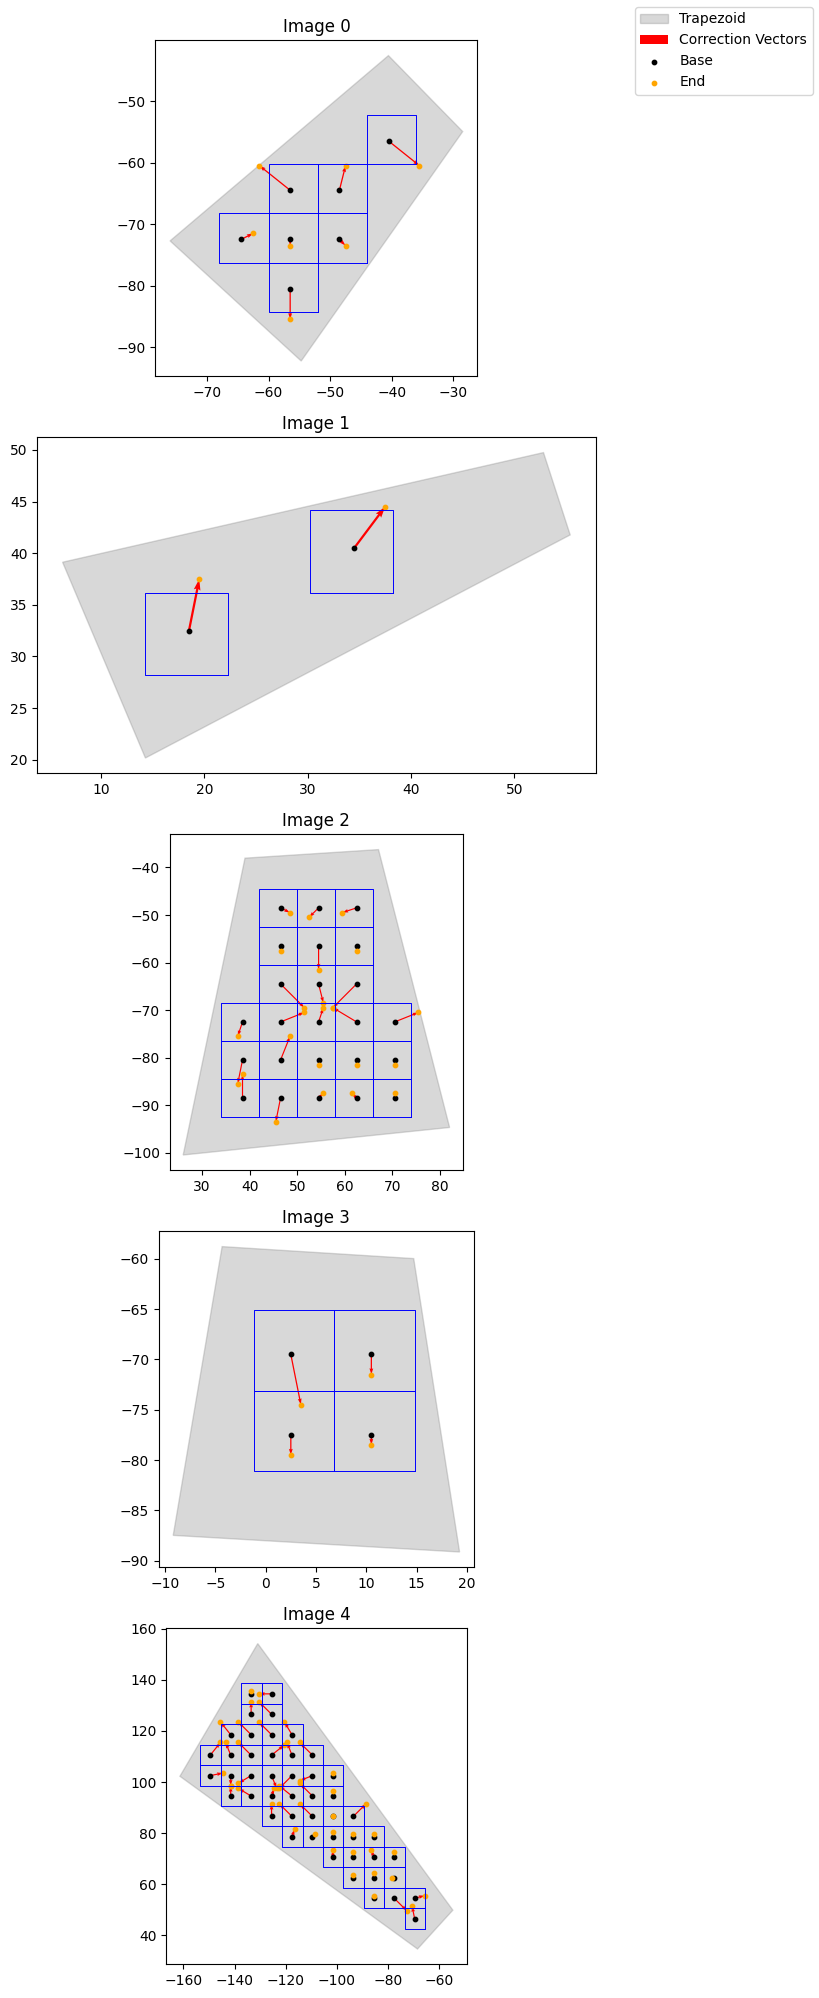

In [24]:
# Plot micropatches and error correction vectors
mdb_plotter.plot_microps_w_corVecs()

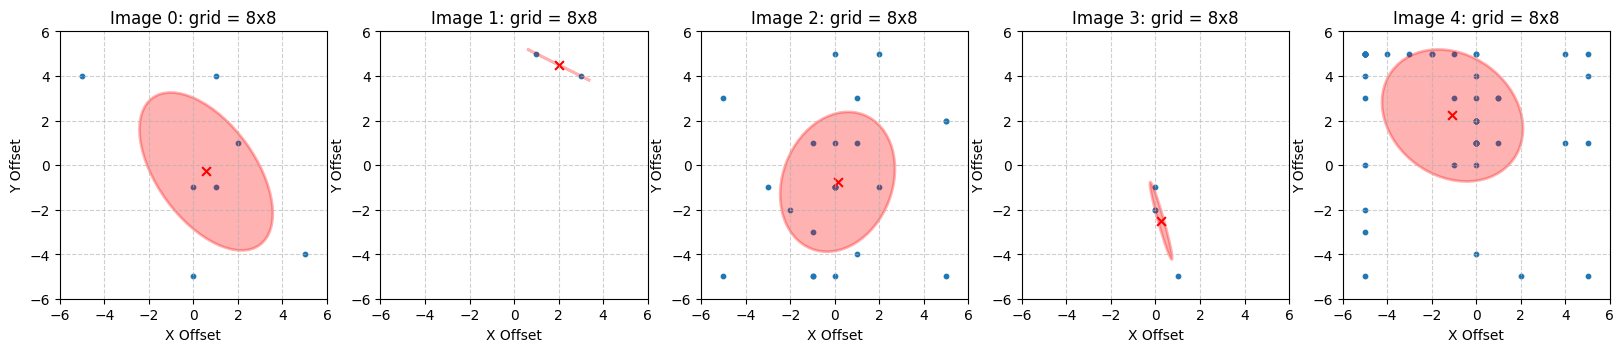

In [25]:
# Plot distribution vectors 
mdb_plotter.plot_distb_vecs(mpa.distb_vecs, mpa.full_mp_mean_var)

# Micropatch confidence level 

Determining the confidence directions for each micropatch, to contribute to full patch correction (and covariance)

Utilizing Softmax function (Boltzman distribution)

### Softmax Function for SSD-Based Confidence

Given scores $s_1, s_2, \ldots, s_n$, the softmax function converts them into probabilities:

$$
p_i = \frac{\exp(s_i)}{\sum_j \exp(s_j)}
$$

Softmax: Larger scores receive exponentially more weight.


## Applying Softmax to SSD Values

**lower SSD is better**, we convert SSD into softmax scores by negating them. We also subtract the minimum SSD value for numerical stability:

$$
p(\Delta x, \Delta y)
=
\frac{
    \exp\!\big(
        -\beta \big[
            \mathrm{SSD}(\Delta x, \Delta y)
            - \mathrm{SSD}_{\min}
        \big]
    \big)
}{
    \displaystyle
    \sum_{u=-5}^{5}
    \sum_{v=-5}^{5}
    \exp\!\big(
        -\beta \big[
            \mathrm{SSD}(u, v)
            - \mathrm{SSD}_{\min}
        \big]
    \big)
}
$$

Where:

- **SSD(Δx, Δy)**  
  The SSD value at shift $(\Delta x, \Delta y)$ in the 11×11 grid.

- **SSD_min**  
  The minimum SSD value (stability)

- **β (beta)**  
  A positive scalar controlling sharpness of the distribution.
  - Using 1/std of ssd values
  - Larger β: more peaked probabilities (higher confidence)  
  - Smaller β: flatter probabilities (lower confidence)

## Mean and std

This probabilistic representation allows computation of:

Mean shift vector:

$$
\mu
=
\begin{bmatrix}
\mu_x \\
\mu_y
\end{bmatrix}
=
\sum_{u=-5}^{5}
\sum_{v=-5}^{5}
p(u,v)
\begin{bmatrix}
u \\
v
\end{bmatrix}
$$

Covariance matrix:

$$
\Sigma
=
\sum_{u=-5}^{5}
\sum_{v=-5}^{5}
p(u,v)
\left(
\begin{bmatrix}
u \\
v
\end{bmatrix}
-
\mu
\right)
\left(
\begin{bmatrix}
u \\
v
\end{bmatrix}
-
\mu
\right)^{T}
$$



STEPS:
- [x] Grab ssd values for each FULL PATCH
- [x] Implement softmax function
- [x] Generate new correction and covariance from probability distribution
- [x] Verify test makes sense visually

# Full Patch Softmax 

In [26]:
# # Through each patch and micro-patch, generate probability distb
# mpa.prob_distb_FP = [{} for _ in range(gnav.im_num)]
# mpa.ssds_curr_SM = [{} for _ in range(gnav.im_num)]
# maxp = 0
# for imnum in range(gnav.im_num):
#     # Grab ssds - FOR FULL PATCH
#     ssds = gnav.ssd_nxn(n_ssd, imnum)
#     mpa.ssds_curr_SM[imnum] = ssds

In [27]:
# # Save SSDs for runtime help 
# # Save data as pickle 
# fn = 'ssd_curr_SM.pkl'
# with open(fn, 'wb') as f:
#     pickle.dump(gnav.ssds_curr_SM, f)

# Import pickle data structure so we do not have to run again
# Load
with open('ssd_curr_SM.pkl', 'rb') as f:
    ssds_curr_SM = pickle.load(f)

mpa.ssds_curr_SM = ssds_curr_SM
gnav.ssds_curr_SM = ssds_curr_SM

In [28]:
# Softmax distribution for each FULL patch - generates mpa.prob_distb_FP
mpa.FP_softmax()
# print(mpa.prob_distb_FP[0]['cov'])

### Plot ORIGINAL micropatch distribution vecs vs. softmax for full image patches 

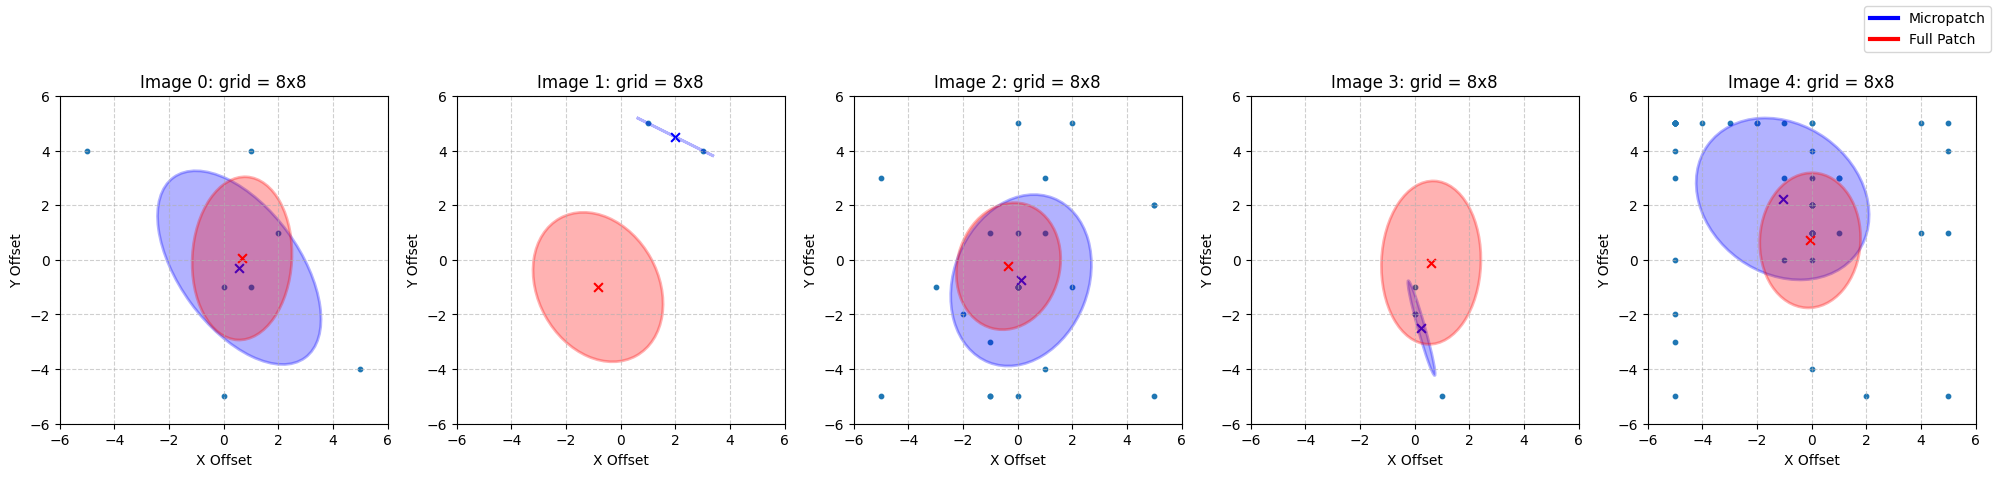

In [29]:
mdb_plotter.plot_softmax_microp_COMP(mpa.distb_vecs, mpa.full_mp_mean_var, mpa.prob_distb_FP)

#### SSD Surface plots

In [30]:
# # Plot each SSD surface plot 
# # %matplotlib qt
# for imnum in range(gnav.im_num):
#     mdb_plotter.ssd_surface_plots(gnav.ssds_curr_SM[imnum], imnum, n_ssd)
#     # mdb_plotter.ssd_surface_plots(gnav.prob_distb_FP[imnum]['probs'], imnum, n_ssd) # Swap for probabilities?

# Exclusion directions using 2nd Order Moment
- Aiming to turn an SSD into a second order moment
- Utilize the mean and covariance from softmax

STEPS: 
- [x] Set threshold equal to 2nd order moment of rod
- [x] Highlight exclusion directions
- [x] Plot exclusion directions for each micropatch
- [ ] Generate covariance for each micropatch (n covs)
- [ ] Generate an extra covariance for each single-confidence MP (n + x)

In [31]:
# Find elongated images and confidence direction for FULL IMAGE distb - mpa.ims_elong
mpa.elong_ims()


Eigenvalues:
 [3.31866149 8.93804341]
Eigenvectors:
 [[-0.99840878  0.05639074]
 [ 0.05639074  0.99840878]]

Image 0 is ELONGATED
ANGLE: 86.76733357806356
V perpendicular [ 0.99840878 -0.05639074]

Eigenvalues:
 [4.85524866 8.29175042]
Eigenvectors:
 [[-0.87471548 -0.4846368 ]
 [-0.4846368   0.87471548]]

Image 1 is ELONGATED
ANGLE: 118.98867909632233
V perpendicular [-0.87471548 -0.4846368 ]

Eigenvalues:
 [3.52303424 5.53480458]
Eigenvectors:
 [[-0.96698435  0.25483575]
 [ 0.25483575  0.96698435]]

Eigenvalues:
 [3.30933027 8.94718656]
Eigenvectors:
 [[-0.99923339  0.03914897]
 [ 0.03914897  0.99923339]]

Image 3 is ELONGATED
ANGLE: 87.75635598014945
V perpendicular [ 0.99923339 -0.03914897]

Eigenvalues:
 [3.39887466 6.12225645]
Eigenvectors:
 [[-0.99813216  0.06109165]
 [ 0.06109165  0.99813216]]


In [32]:
# # Direction of uncertainty
# for i in range(mpa.num_elong):
#     imnum = mpa.ims_elong[i*2]
#     print(imnum)
#     v_perp = mpa.ims_elong[i*2 + 1]
#     print(v_perp)

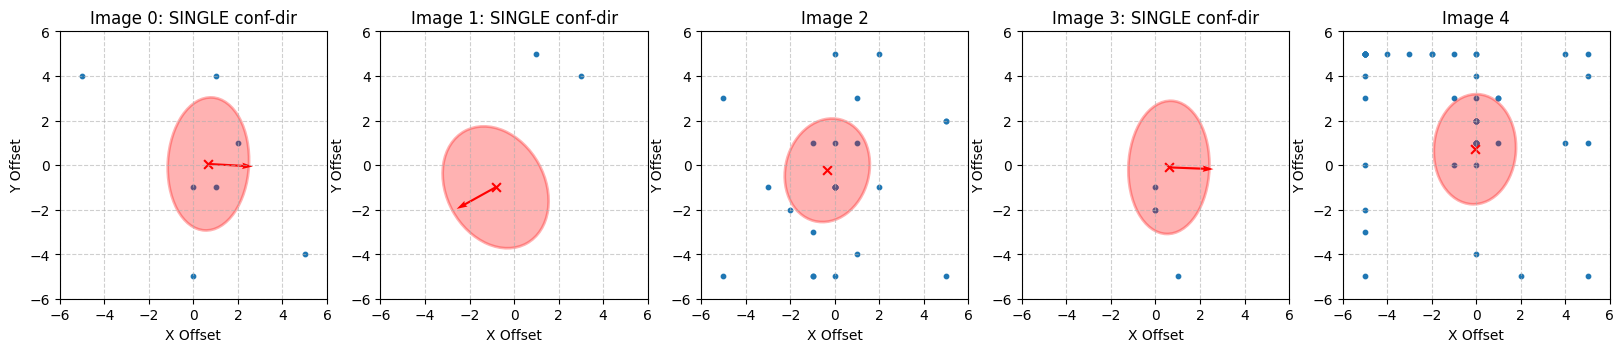

In [33]:
mdb_plotter.plot_softmax_and_confdir(mpa.distb_vecs, mpa.prob_distb_FP, mpa.ims_elong)

### Eliminate 'bad' micropatches based on exclusion directions

Steps:
For each micropatch
- [x] Grab ssd of MP
- [x] Probability distb from softmax
- [x] Determine if softmax kills the point (no direction preserved)
- [ ] Remove blue points
- [ ] Get distribution from new blue points
- [ ] Compare to softmax of full patch 

In [34]:
# Determine exclusion directions based on threshold - mpa.sm_distb_conf
mpa.exclusion_dirs()
print("EXCLUSION DIRECTIONS:", mpa.sm_distb_conf[0])

Total micropatches: 85
Micropatches with less than 2 confidence directions: 76
Micropatches with less than NO confidence directions: 3
EXCLUSION DIRECTIONS: {0: {'mu': array([0.76227442, 0.2958653 ]), 'cov': array([[6.53832994, 0.14811753],
       [0.14811753, 9.05272669]]), 'cdirs': 1, 'eigvals': array([6.52963474, 9.0614219 ]), 'eigvecs': array([[-0.99828132,  0.05860387],
       [ 0.05860387,  0.99828132]])}, 1: {'mu': array([-0.5830163 , -0.50936163]), 'cov': array([[4.60076323, 0.26551609],
       [0.26551609, 9.74777999]]), 'cdirs': 1, 'eigvals': array([4.58710246, 9.76144075]), 'eigvecs': array([[-0.99867908,  0.05138189],
       [ 0.05138189,  0.99867908]])}, 2: {'mu': array([0.58074536, 0.19709871]), 'cov': array([[4.19469279, 0.78365937],
       [0.78365937, 7.70391892]]), 'cdirs': 1, 'eigvals': array([4.02764277, 7.87096894]), 'eigvecs': array([[-0.97802609,  0.20848252],
       [ 0.20848252,  0.97802609]])}, 3: {'mu': array([-1.65232427,  0.55389353]), 'cov': array([[ 5.544

### Plotting individual micropatch distributions

Attempting to use the mean and covariance from the softmax to visualize the distribution of each micropatch, to eventually determine the usefulness of each micropatch

In [35]:
# imnum = 0
# mdb_plotter.plot_microp_distb_singleIM(imnum)

## Plot confidence levels

In [36]:
print(mpa.full_mp_mean_var[0])

{'mu': array([ 0.57142857, -0.28571429]), 'cov': array([[ 8.95238095, -5.64285714],
       [-5.64285714, 12.57142857]])}


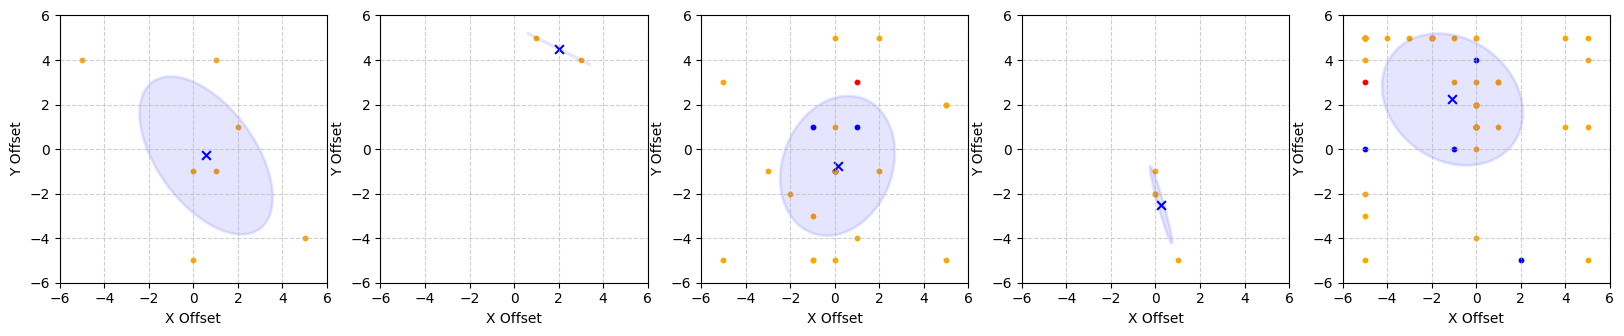

In [37]:
mdb_plotter.plot_distb_vecs_updated()

### Utilizing just blue (multi-direction) points

- [x] Isolate only blue points 
- [x] Calculate new mean and cov with only blue points

In [38]:
# Isolate BLUE: mpa.distb_vecs_blue with mean and covariance of just blue points
mpa.blue_isolation()
# mpa.yellow_isolation()

# print("Distibution points for BLUE PTS:", mpa.distb_vecs_blue)
print("Mean and variance for blue points:", mpa.full_mp_mean_var_BLUE)

Mean and variance for blue points: [{'mu': array([0, 0]), 'cov': array([[0., 0.],
       [0., 0.]])}, {'mu': array([0, 0]), 'cov': array([[0., 0.],
       [0., 0.]])}, {'mu': array([0., 0.]), 'cov': array([[0.66666667, 0.        ],
       [0.        , 1.33333333]])}, {'mu': array([0, 0]), 'cov': array([[0., 0.],
       [0., 0.]])}, {'mu': array([-0.8,  0. ]), 'cov': array([[ 6.7, -2.5],
       [-2.5, 10.5]])}]


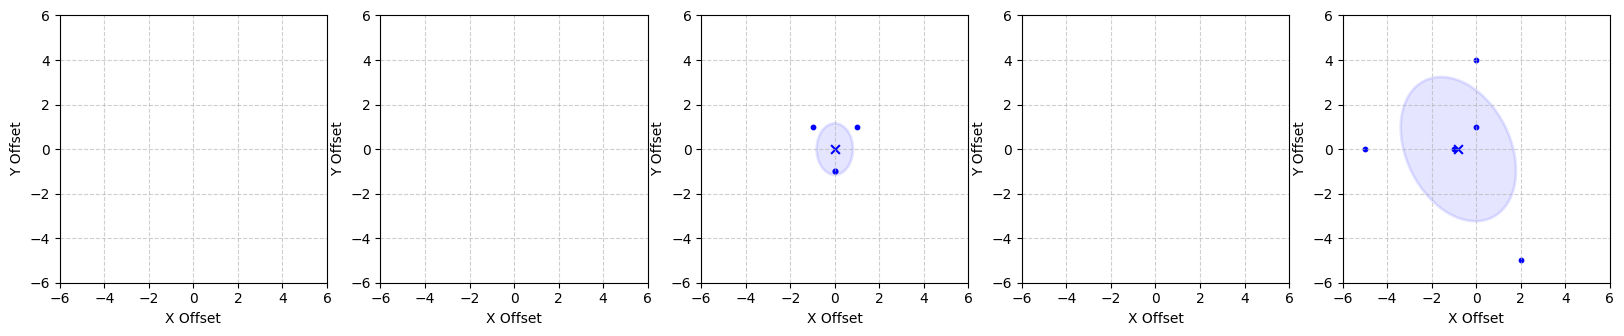

In [39]:
mdb_plotter.plot_distb_vecs_BLUE()

### Error space plot emphasizing single direction confidence

- [x] Isolate single-direction points (yellow)
- [x] Obtain eigenvalue decomposition of yellow points
- [x] Dot SSD error component with minor axis (E_minor = E dot R_minor)
- [x] Get projection E_proj = E_minor dot R_i(eigenvector) (keeps minor axis, removes major)
- [x] Visualize error points, projection, and minor axis

In [40]:
# YELLOW point distributions: mpa.distb_vecs_yellow AND mpa.projection_yellow
mpa.yellow_minor()

In [41]:
# print(len(mpa.projection_yellow[2]))
# print(len(mpa.distb_vecs[2]))
print(mpa.projection_yellow[0])
print(mpa.distb_vecs_yellow[0])
# print(mpa.projection_yellow[0][:,0])

[[ 1.93462802 -0.11357189]
 [ 0.2565701  -0.01320049]
 [ 0.20390134 -0.04346496]
 [-3.80539293 -0.92334557]
 [ 0.78340242  0.14782951]
 [ 0.34876139 -0.05599778]
 [ 5.58812739 -1.15532894]]
[[ 2.  1.]
 [ 0. -5.]
 [ 0. -1.]
 [-5.  4.]
 [ 1. -1.]
 [ 1.  4.]
 [ 5. -4.]]


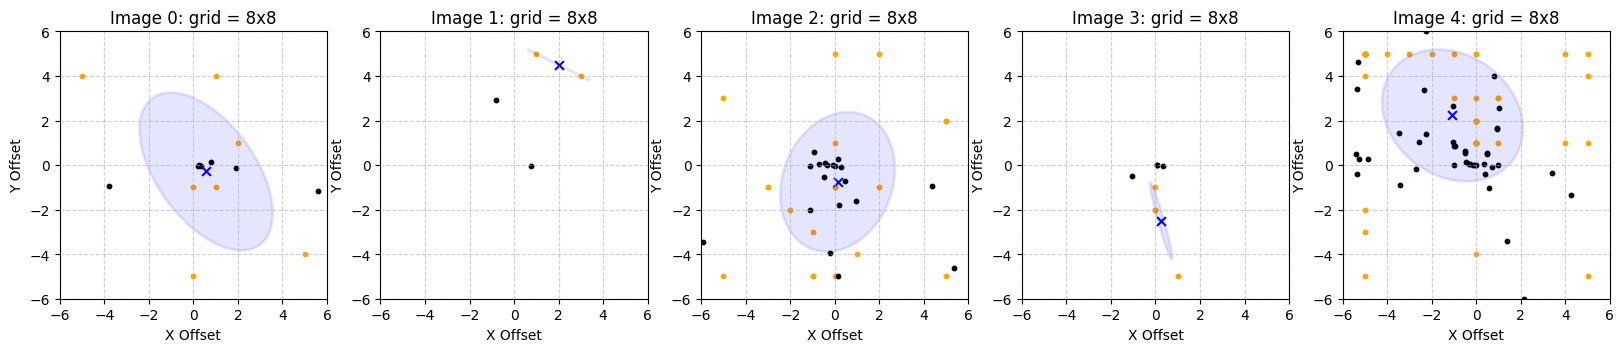

In [42]:
# PLOTTER 
mdb_plotter.plot_distb_vecs_w_singleDIR()

### Plot confidence on image 
- Plotting green, yellow, red marks on physical image plot

TODO:
- [ ] Plot actual error vectors on physical space plot
- [ ] narrow in on green plots in blank space

In [43]:
# print(mpa.sm_distb_conf[0])
print(mpa.full_mp_mean_var[0])
print(mpa.sm_distb_conf[0][0]['cdirs'])

{'mu': array([ 0.57142857, -0.28571429]), 'cov': array([[ 8.95238095, -5.64285714],
       [-5.64285714, 12.57142857]])}
1


In [44]:
mdb_plotter.phys_microp_conf(sat_map=True)

libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 81
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 81
pci id for fd 81: 8086:a7a0, driver iris
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using DRI3 for screen 0


# Error covariance model

- Looking to compare the model covariance (prediction) vs the data covariance (validation)
- MODEL Covariance:
    - Model currently consists of the LSquares process